# 2.) Exploration of the E-MFD 

In this notebook, we explore the E-MFD for usage within Affect Misattribution Procedures (`AMP`) and Lexical Decision Tasks (`LDT`). 

In [4]:
import pandas as pd
import numpy as np

# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from functions import make_wordclouds

# NLP
import spacy, re, fnmatch 
nlp = spacy.load('en')

plt.style.use('seaborn-paper')
sns.set_style('whitegrid')
plt.rcParams['font.serif'] = "Times New Roman"

In [44]:
amp = pd.read_pickle('dictionaries/emfd_amp.pkl')[['word','care_norm','fairness_norm','authority_norm','loyalty_norm','sanctity_norm','ind_comp']]

### 1) Construct WordClouds for Highest Weighted Words

In [45]:
foundations = ['care','fairness','loyalty','authority','sanctity']

In [46]:
# Add vice, virtue columns        
virtues = [f+'.virtue' for f in foundations]
vices = [f+'.vice' for f in foundations]

for f in virtues:
    amp[f] = 0.0
for f in vices:
    amp[f] = 0.0

# Transfer weights to vice-virtue columns
for i, row in amp.iterrows():
    if row['ind_comp'] < 0:
        amp.at[i,'care.vice'] = row.care_norm
        amp.at[i,'fairness.vice'] = row.fairness_norm
        amp.at[i,'loyalty.vice'] = row.loyalty_norm
        amp.at[i,'authority.vice'] = row.authority_norm
        amp.at[i,'sanctity.vice'] = row.sanctity_norm
    else :
        amp.at[i,'care.virtue'] = row.care_norm
        amp.at[i,'fairness.virtue'] = row.fairness_norm
        amp.at[i,'loyalty.virtue'] = row.loyalty_norm
        amp.at[i,'authority.virtue'] = row.authority_norm
        amp.at[i,'sanctity.virtue'] = row.sanctity_norm
        
amp['foundation'] = amp[virtues+vices].idxmax(axis=1).astype(str)

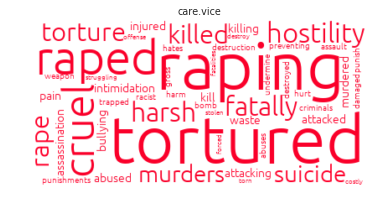

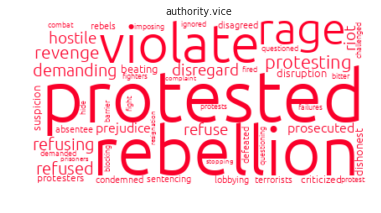

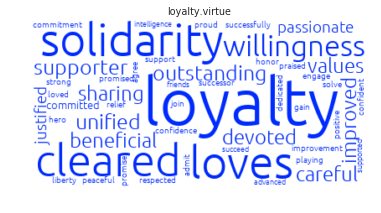

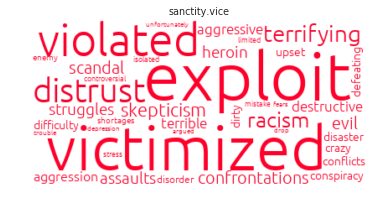

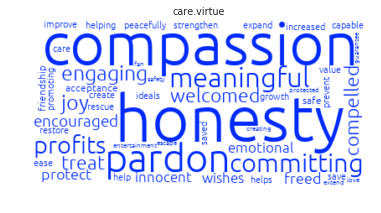

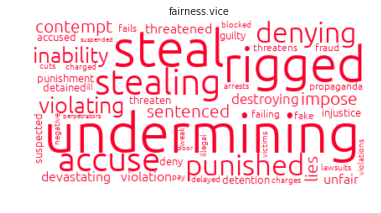

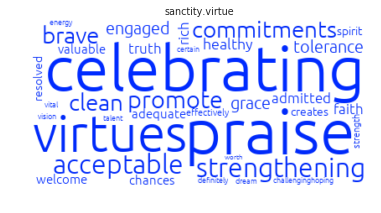

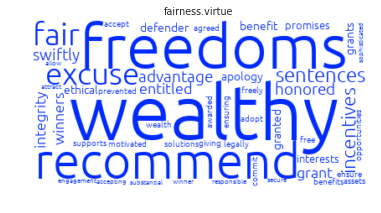

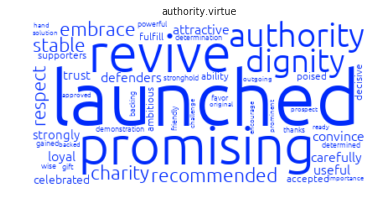

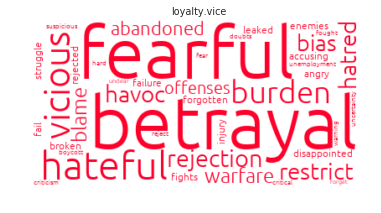

In [47]:
make_wordclouds(amp)

In [50]:
amp.to_pickle('dictionaries/emfd_amp.pkl')

Text(0.5, 1.0, 'Words per Foundation in the AMP E-MFD')

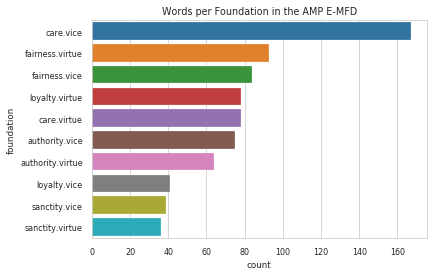

In [14]:
sns.countplot(y='foundation',data=amp, order=amp.foundation.value_counts().index)
plt.title("Words per Foundation in the AMP E-MFD")

### 2) Compare weights across foundations in E-MFD Scoring

In [5]:
emfd = pd.read_pickle('dictionaries/emfd_scoring.pkl')[['word','care_norm','fairness_norm','authority_norm','loyalty_norm','sanctity_norm','tag']]
weights = [c for c in emfd.columns if c.endswith('_norm')]

Text(0.5, 1.0, 'Average Weights Across Foundations')

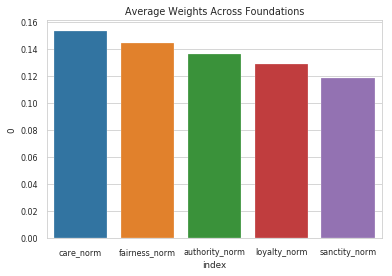

In [71]:
sns.barplot(x='index', y=0, data = emfd[weights].mean().reset_index())
plt.title('Average Weights Across Foundations')

Text(0.5, 1.0, 'Part of Speech Tags in the E-MFD')

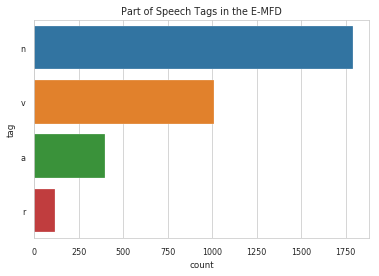

In [72]:
sns.countplot(y='tag',data=emfd, order=emfd.tag.value_counts().index)
plt.title("Part of Speech Tags in the E-MFD")

### 3) Run PCA on E-MFD

In [6]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

In [7]:
emfd = emfd.rename(columns={'care_norm':'care','fairness_norm':'fairness','authority_norm':'authority',
                            'loyalty_norm':'loyalty','sanctity_norm':'sanctity'})
del emfd['word']

In [8]:
emfd = emfd[['care','fairness','loyalty','authority','sanctity']]

In [9]:
emfd = emfd.reset_index()

In [10]:
features = ['care','fairness','loyalty','authority','sanctity']

In [11]:
# Separating out the features
x = emfd.loc[:, features].values

# Separating out the target
y = emfd.loc[:,['word']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [41]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)

In [42]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [39]:
finalDf = pd.concat([principalDf, emfd[['word']]], axis = 1)

In [40]:
pcs = finalDf.loc[:, ['principal component 1', 'principal component 2']].values
pcs_scaled = normalize(pcs)

In [43]:
targets = emfd.word

In [44]:
finalDf = finalDf.head(1000)

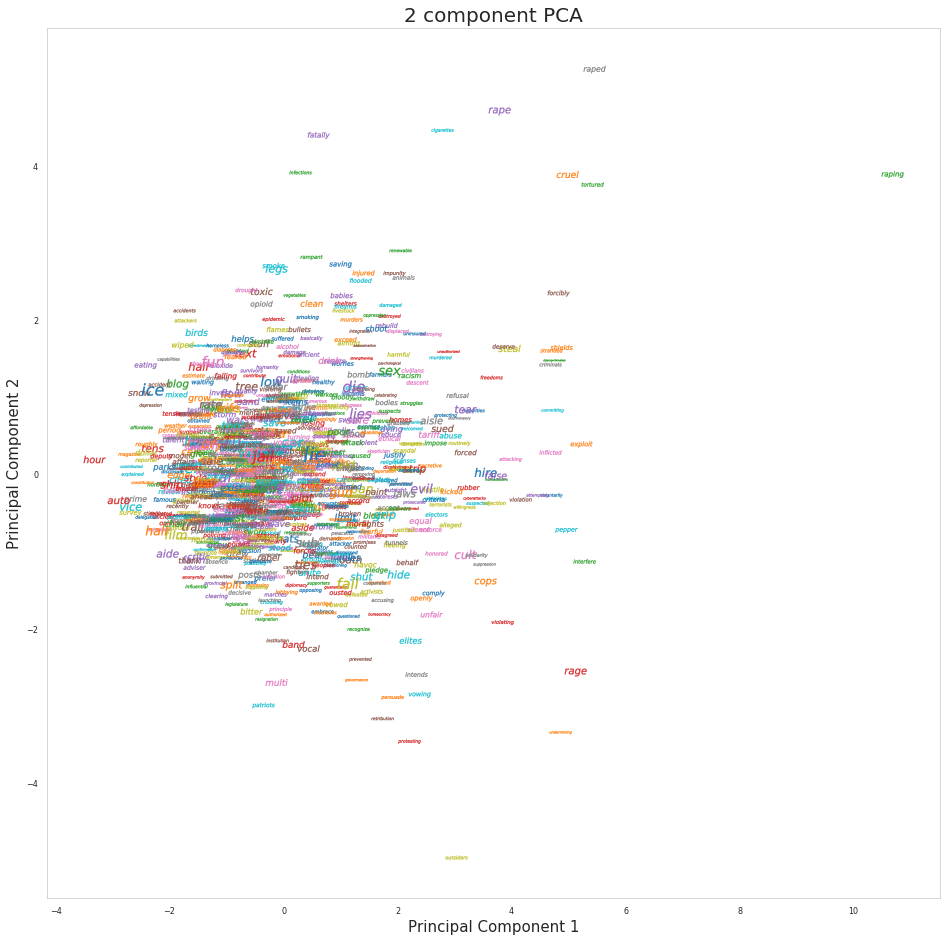

In [45]:
fig = plt.figure(figsize = (16,16))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = finalDf.word
# colors = ['r', 'g', 'b']
for target in targets:
    indicesToKeep = finalDf['word'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
#                , c = color
               , marker=r"$ {} $".format(target)
               , s = 500)
# ax.legend(targets)
ax.grid()